# SMCNOD - Exploratory data analysis
### Aims:
- Learn about the dataset we are using
- Visualize features we are interested in putting into our model
- Initial guess of components for future mixture model / clustering

In [88]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
from scipy.stats import gaussian_kde
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import imp
import seaborn as sns
import pandas as pd
from astropy import units as u

## Data
S5

In [3]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5

absdev_1700d_0,absdev_580v_0,alpha1,alpha16,alpha50,alpha84,alpha99,alpha_kurt,alpha_mean,alpha_skew,alpha_std,chisq_1700d_0,chisq_580v_0,chisq_cont_1700d_0,chisq_cont_580v_0,comment,dec,feh1,feh16,feh50,feh84,feh99,feh_kurt,feh_mean,feh_skew,feh_std,field,fig_name,fileinfo,logg1,logg16,logg50,logg84,logg99,logg_kurt,logg_mean,logg_skew,logg_std,name,nspec_1700d,nspec_580v,prior_type,proc_file_list,ra,redchisq_1700d_0,redchisq_580v_0,sn_1700d_0,sn_580v_0,teff1,teff16,teff50,teff84,teff99,teff_kurt,teff_mean,teff_skew,teff_std,utmjd,utmjd_mean,vel1,vel16,vel50,vel84,vel99,vel_blue1,vel_blue16,vel_blue50,vel_blue84,vel_blue99,vel_blue_kurt,vel_blue_mean,vel_blue_skew,vel_blue_std,vel_kurt,vel_mean,vel_skew,vel_std,fname,absdev_580v_1,chisq_580v_1,chisq_cont_580v_1,redchisq_580v_1,sn_580v_1,absdev_1700d_1,chisq_1700d_1,chisq_cont_1700d_1,redchisq_1700d_1,sn_1700d_1,absdev_1700d_2,chisq_1700d_2,chisq_cont_1700d_2,redchisq_1700d_2,sn_1700d_2,absdev_580v_2,chisq_580v_2,chisq_cont_580v_2,redchisq_580v_2,sn_580v_2,absdev_1700d_3,absdev_1700d_4,absdev_1700d_5,absdev_580v_3,absdev_580v_4,absdev_580v_5,chisq_1700d_3,chisq_1700d_4,chisq_1700d_5,chisq_580v_3,chisq_580v_4,chisq_580v_5,chisq_cont_1700d_3,chisq_cont_1700d_4,chisq_cont_1700d_5,chisq_cont_580v_3,chisq_cont_580v_4,chisq_cont_580v_5,redchisq_1700d_3,redchisq_1700d_4,redchisq_1700d_5,redchisq_580v_3,redchisq_580v_4,redchisq_580v_5,sn_1700d_3,sn_1700d_4,sn_1700d_5,sn_580v_3,sn_580v_4,sn_580v_5,ebv,gaia_source_id,dr2_source_id,phot_bp_rp_excess_factor,parallax,parallax_error,phot_g_mean_mag,source_id,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_bp_mean_mag,phot_rp_mean_mag,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,bjdist_flag,w1mpro,w2mpro,w1sigmpro,w2sigmpro,j_2mass,h_2mass,k_2mass,u_skm,e_u_skm,v_skm,e_v_skm,g_skm,e_g_skm,r_skm,e_r_skm,i_skm,e_i_skm,z_skm,e_z_skm,starhorse_dist05,starhorse_dist16,starhorse_dist50,starhorse_dist84,starhorse_dist95,decam_g,decam_r,decam_i,decam_z,decam_phot_src_bits,qso_flag_wise,priority,object_name,sesar_s3ab,sesar_s3c,gaia_rr,p_bhb_decals,best_chisq_580v,best_absdev_580v,best_sn_580v,best_chisq_1700d,best_absdev_1700d,best_sn_1700d,good_star_pb,good_star,vel_calib,vel_calib_std,feh_calib_std,mass1,mass16,mass50,mass84,mass99,mass_mean,mass_std,mass_kurt,mass_skew,logage1,logage16,logage50,logage84,logage99,logage_mean,logage_std,logage_kurt,logage_skew,sp_feh1,sp_feh16,sp_feh50,sp_feh84,sp_feh99,sp_feh_mean,sp_feh_std,sp_feh_kurt,sp_feh_skew,sp_alpha1,sp_alpha16,sp_alpha50,sp_alpha84,sp_alpha99,sp_alpha_mean,sp_alpha_std,sp_alpha_kurt,sp_alpha_skew,logdist1,logdist16,logdist50,logdist84,logdist99,logdist_mean,logdist_std,logdist_kurt,logdist_skew,lmag_sys1,lmag_sys16,lmag_sys50,lmag_sys84,lmag_sys99,lmag_sys_mean,lmag_sys_std,lmag_sys_kurt,lmag_sys_skew,npost,sp_feh_calib_std,GDR3_solution_id,GDR3_source_id,GDR3_classprob_dsc_combmod_quasar,GDR3_classprob_dsc_combmod_galaxy,GDR3_classprob_dsc_combmod_star,GDR3_classprob_dsc_combmod_whitedwarf,GDR3_classprob_dsc_combmod_binarystar,GDR3_classprob_dsc_specmod_quasar,GDR3_classprob_dsc_specmod_galaxy,GDR3_classprob_dsc_specmod_star,GDR3_classprob_dsc_specmod_whitedwarf,GDR3_classprob_dsc_specmod_binarystar,GDR3_classprob_dsc_allosmod_quasar,GDR3_classprob_dsc_allosmod_galaxy,GDR3_classprob_dsc_allosmod_star,GDR3_teff_gspphot,GDR3_teff_gspphot_lower,GDR3_teff_gspphot_upper,GDR3_logg_gspphot,GDR3_logg_gspphot_lower,GDR3_logg_gspphot_upper,GDR3_mh_gspphot,GDR3_mh_gspphot_lower,GDR3_mh_gspphot_upper,GDR3_distance_gspphot,GDR3_distance_gspphot_lower,GDR3_distance_gspphot_upper,GDR3_azero_gspphot,GDR3_azero_gspphot_lower,GDR3_azero_gspphot_upper,GDR3_ag_gspphot,GDR3_ag_gspphot_lower,GDR3_ag_gspphot_upper,GDR3_abp_gspphot,GDR3_abp_gspphot_lower,GDR3_abp_gspphot_upper,GDR3_arp_gspphot,GDR3_arp_gspphot_lower,GDR3_arp_gspphot_upper,GDR3_ebpminrp_gspphot,GDR3_ebpminrp_gspphot_lower,GDR3_ebpminrp_gspphot_upper,GDR3_mg_gspphot,GDR3_mg_gspphot_lower,GDR3_mg_gspphot_upper,GDR3

## Basic Visualization

In [127]:
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
high_quality = (c1 | c2) & c3 & c4
table_cut = table_cut[high_quality]

In [171]:
alpha3 = np.radians(table_cut['ra'])
delta3 = np.radians(table_cut['dec'])
angular_sep_rad_new = np.arccos(np.sin(delta1) * np.sin(delta3) + \
                            np.cos(delta1) * np.cos(delta3) * np.cos(alpha1 - alpha3))
table_cut['angular_sep_rad'] = angular_sep_rad_new

In [128]:
galcen = SkyCoord(12, -64.8, unit="deg")
gcoo = galcoo = SkyCoord(table_cut["ra"], table_cut["dec"], unit="deg", radial_velocity=table_cut["vel_calib"]*u.km/u.s)
table_cut["R"] = galcen.separation(gcoo).deg
table_cut["BP-RP"] = table_cut["phot_bp_mean_mag"] - table_cut["phot_rp_mean_mag"]
table_cut["G"] = table_cut["phot_g_mean_mag"]

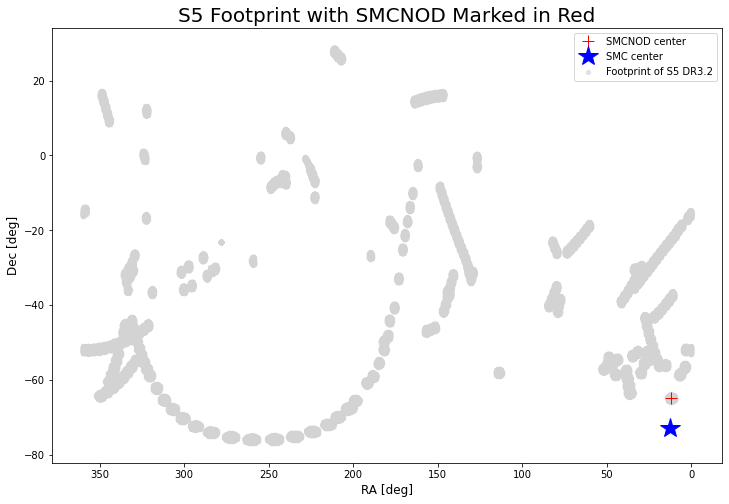

In [129]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(table_S5['ra'],table_S5['dec'], marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Footprint of S5 DR3.2')
ax.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
ax.plot(RA_smc, DEC_smc,'*b',ms=20,label="SMC center")
ax.set_xlabel('RA [deg]', size=12)
ax.set_ylabel('Dec [deg]', size=12)
ax.set_title('S5 Footprint with SMCNOD Marked in Red', fontsize=20)
ax.invert_xaxis()
ax.legend()

## Variable selection
In this study, we are interested in the variables below:
### Coordinate
- ra: Right ascension of the object
- dec: Declination of the object
### Quality Parameters
- best_sn_1700d: Median Signal-to-Noise ratio of the 1700d spectra (red arm measure more RGB).
- best_sn_580v: Median Signal-to-Noise ratio of the 580d spectra (blue arm more BHB).
- good_star_pb: Good star probability based on random forest trained on a set of parameters. See details in Section 4.5 of Li et al. (2019)
### Proper Motion
- pmra: Measurements of proper motion given in the direction of right ascension from Gaia eDR3
- pmra_error: Measurement error for pmra
- pmdec: Measurements of proper motion given in the direction of declination from Gaia eDR3
- pmdec_error: Measurement error for pmdec
### Radial Velocity
- vel_calib: Radial velocity (RV) calibrated statistics from rvspecfit.
- vel_calib_std: calibrated radial velocity uncertainty using repeated observations
### Stellar Parameters 
#### Metallicity 
- feh50: mean metallicity for each star.
- feh_calib_std: Calibrated [Fe/H] uncertainty using repeated observations.
#### Surface Gravity
- logg50: Surface gravity statistics from rvspecfit.
- logg_std: standard deviation of Surface gravity.
#### Temperature
- teff50: Effective temperature statistics from rvspecfit
- teff_std: standard deviation of effective temperature.

In [33]:
data_feature = table_cut['vel_calib','feh50','pmra','pmdec','logg50','teff50']
df = data_feature.to_pandas()

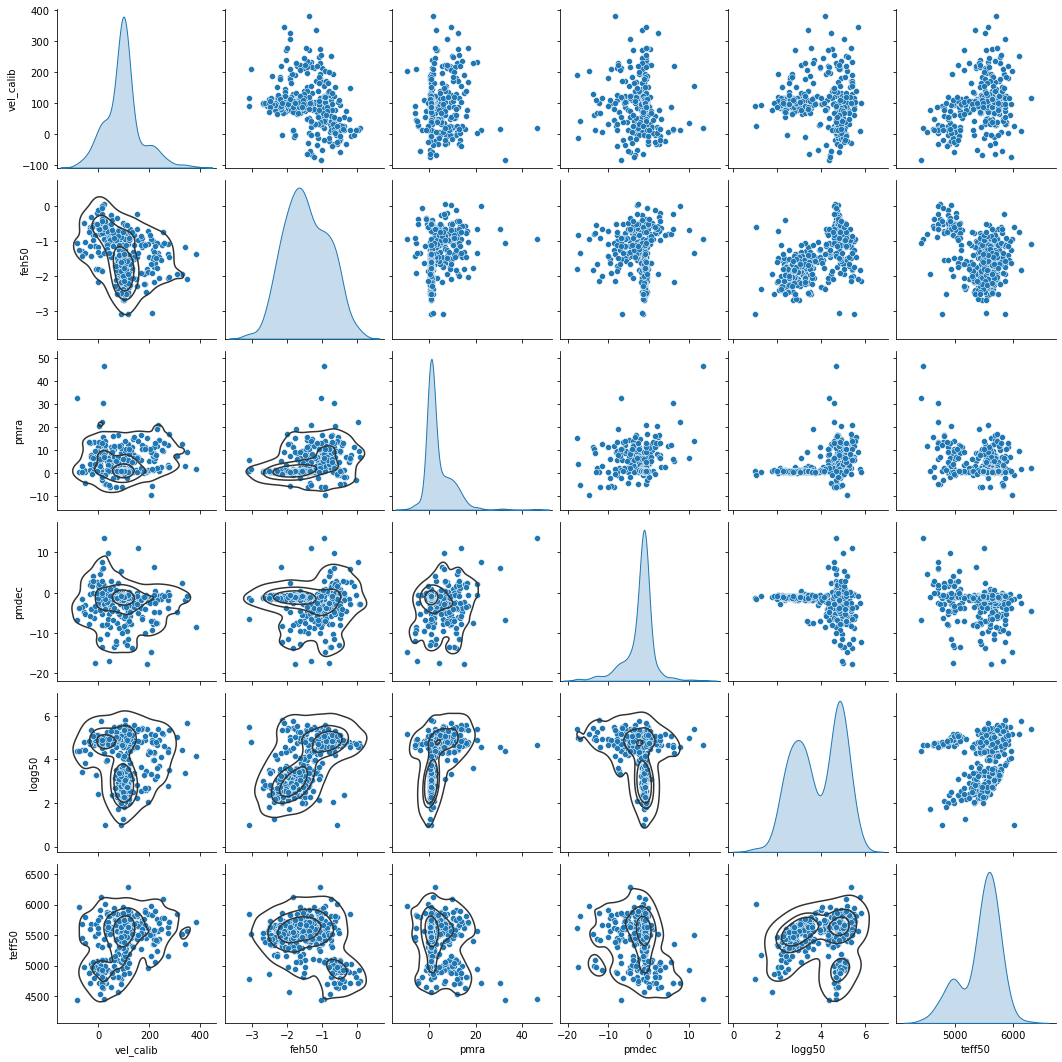

In [158]:
g = sns.pairplot(df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")
plt.savefig('output.png')

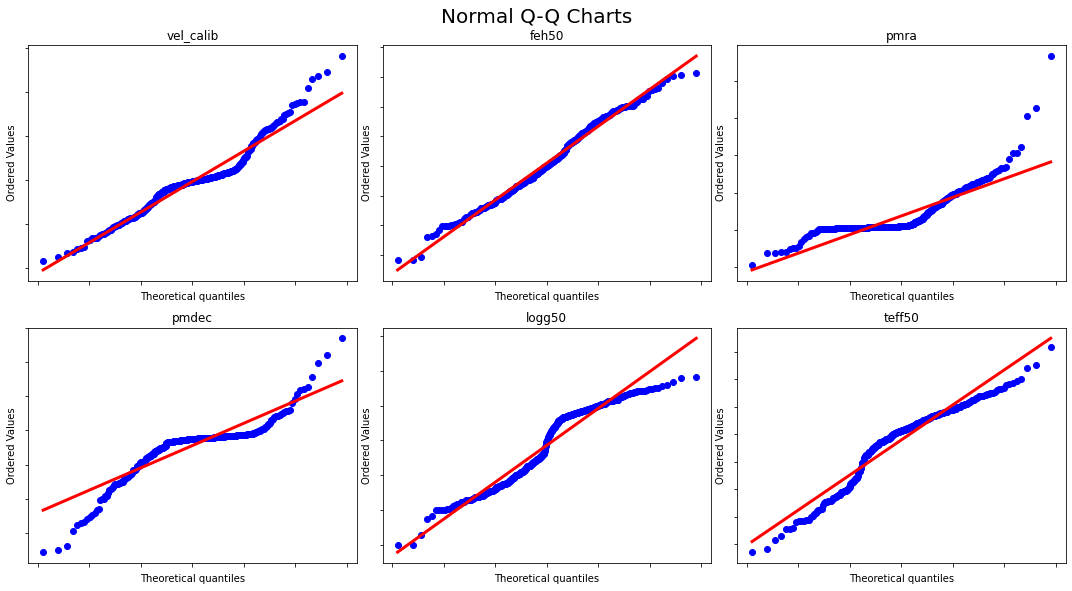

In [64]:
figure = plt.figure(figsize = (15,8))
for i in range(len(df.columns)):
    # Q-Q plot
    ax = plt.subplot(2,3, i+1)
    stats.probplot(df.iloc[:,i], dist='norm', plot=plt)
    # Aesthetics
    ax.get_lines()[0].set_markersize(6.0)
    ax.get_lines()[1].set_linewidth(3.0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title(df.columns[i])
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Normal Q-Q Charts', y=1.02, fontsize=20)
plt.show()

### Comment
- The plot above visualizes distributions in different features using kernel density estimation.
- We can see that through eyeball, there are 2~3 components in each variable.

## (Objective) Member Selection
Here, we would explore the histogram of variables of interest and select the peak to be criteria for SMCNOD member.

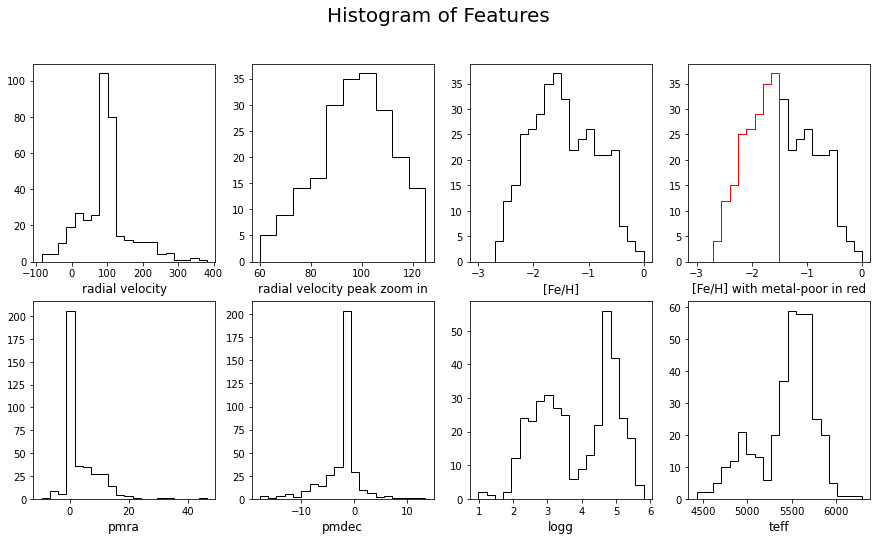

In [145]:
plt.figure(figsize=(15,8))
metalpoor = table_cut['feh50'] < -1.5
plt.suptitle("Histogram of Features", fontsize=20)
# RV
plt.subplot(2,4,1)
plt.hist(table_cut['vel_calib'], bins=20, histtype='step', ec='k')
plt.xlabel('radial velocity', size = 12)
plt.subplot(2,4,2)
plt.hist(table_cut['vel_calib'], bins=10, range=[60,125], histtype='step', ec='k')
plt.xlabel('radial velocity peak zoom in', size = 12)
# [Fe/H]
plt.subplot(2,4,3)
plt.hist(table_cut['feh50'],bins=20,histtype='step',ec='k',range=[-3,0])
plt.xlabel('[Fe/H]',size=12)
plt.subplot(2,4,4)
plt.hist(table_cut['feh50'],bins=20,histtype='step',ec='k',range=[-3,0])
plt.hist(table_cut['feh50'][metalpoor],bins=20,histtype='step',ec='r',range=[-3,0])
plt.xlabel('[Fe/H] with metal-poor in red',size=12)
# pmra, pmdec
plt.subplot(2,4,5)
plt.hist(table_cut['pmra'], bins=20, histtype='step', ec='k')
plt.xlabel('pmra', size = 12)
plt.subplot(2,4,6)
plt.hist(table_cut['pmdec'], bins=20, histtype='step', ec='k')
plt.xlabel('pmdec', size = 12)
# logg
plt.subplot(2,4,7)
plt.hist(table_cut['logg50'], bins=20, histtype='step', ec='k')
plt.xlabel('logg',size=12)
# teff
plt.subplot(2,4,8)
plt.hist(table_cut['teff50'], bins=20, histtype='step', ec='k')   
plt.xlabel('teff',size=12)
plt.show()

### Comment: peak selection
In this stage, we obtain a rough peak selection, with reference:
- Radial Velocity: 60 < table_cut['vel_calib'] < 125.5
- Proper Motion: 0 < table_cut['pmra'] < 1.5, -1.75 < table_cut['pmdec'] < -0.6
- logg: 4 < table_cut['logg50'] < 5.5
- teff: 5400 < table_cut['teff50'] < 5900

In [139]:
sel_peak = (60 <table_cut['vel_calib']) & (table_cut['vel_calib'] < 125.5)
peak_pm = ( 0 < table_cut['pmra'][sel_peak] ) & ( table_cut['pmra'][sel_peak] < 1.5) & (-1.75 < table_cut['pmdec'] [sel_peak]) & (table_cut['pmdec'] [sel_peak] < -0.6)

Text(0, 0.5, 'teff')

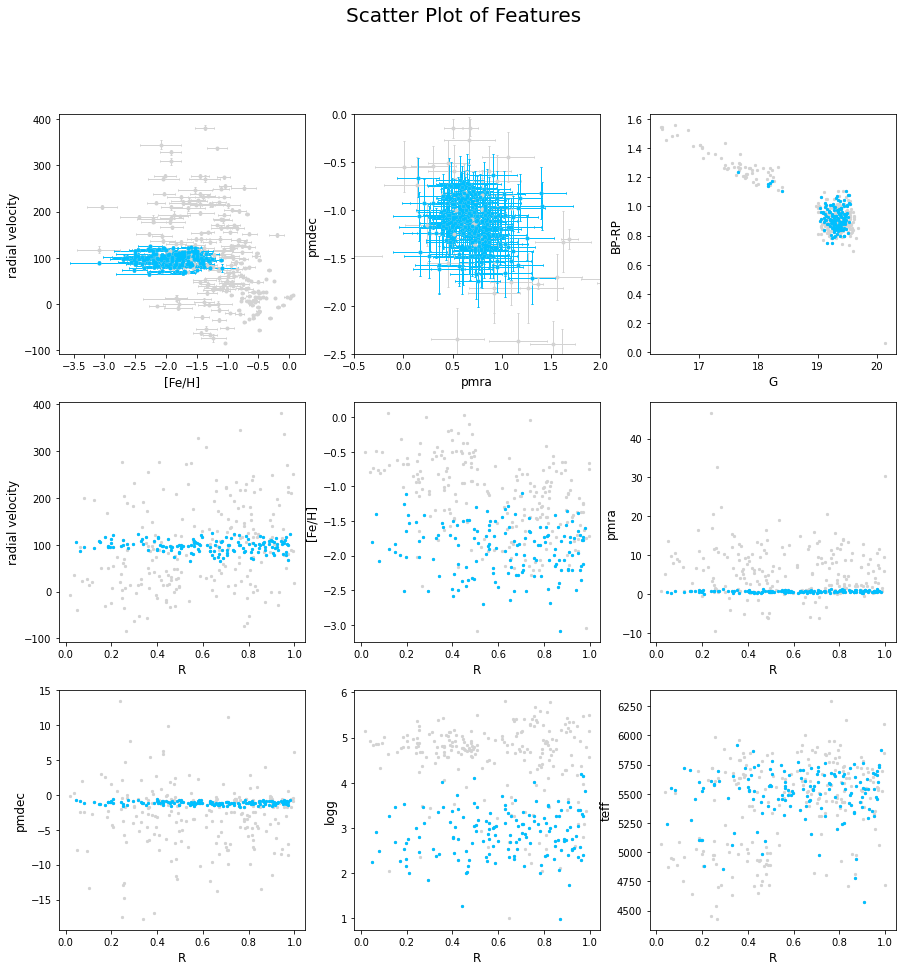

In [156]:
plt.figure(figsize=(15,15))
plt.suptitle("Scatter Plot of Features", fontsize=20)
plt.subplot(3,3,1)
# [Fe/H]-RV
plt.errorbar(table_cut['feh50'],table_cut['vel_calib'],
            xerr=table_cut['feh_calib_std'], yerr = table_cut['vel_calib_std'],
            fmt='.', c='lightgray', label='Stars near SMCNOD', capsize=1,lw=1)
plt.errorbar(table_cut['feh50'][sel_peak][peak_pm],table_cut['vel_calib'][sel_peak][peak_pm],
            xerr=table_cut['feh_calib_std'][sel_peak][peak_pm], yerr = table_cut['vel_calib_std'][sel_peak][peak_pm],
            fmt='.', c='deepskyblue', label='Stars in peak selection', capsize=1,lw=1)
plt.xlabel('[Fe/H]', size = 12)
plt.ylabel('radial velocity', size = 12)
plt.subplot(3,3,2)
# Proper Motion
plt.errorbar(table_cut['pmra'], table_cut['pmdec'],
             xerr=table_cut['pmra_error'], yerr=table_cut['pmdec_error'], 
             fmt='.', c='lightgray', label='Stars near SMCNOD', capsize=1,lw=1)
plt.errorbar(table_cut['pmra'][sel_peak][peak_pm], table_cut['pmdec'][sel_peak][peak_pm],
             xerr=table_cut['pmra_error'][sel_peak][peak_pm], yerr=table_cut['pmdec_error'][sel_peak][peak_pm], 
             fmt='.', c='deepskyblue', label='Stars in peak selection', capsize=1,lw=1)
plt.xlim(-0.5,2)
plt.ylim(-2.5,0)
plt.xlabel('pmra', size = 12)
plt.ylabel('pmdec', size = 12)
plt.subplot(3,3,3)
# G - BP-RP
plt.scatter(table_cut['G'], table_cut['BP-RP'], c='lightgray',s=5)
plt.scatter(table_cut['G'][sel_peak][peak_pm], table_cut['BP-RP'][sel_peak][peak_pm], c='deepskyblue',s=5)
plt.xlabel('G', size = 12)
plt.ylabel('BP-RP', size = 12)
plt.subplot(3,3,4)
# R - RV
plt.scatter(table_cut['R'], table_cut['vel_calib'], c='lightgray',s=5)
plt.scatter(table_cut['R'][sel_peak][peak_pm], table_cut['vel_calib'][sel_peak][peak_pm], c='deepskyblue',s=5)
plt.xlabel('R', size = 12)
plt.ylabel('radial velocity', size = 12)
plt.subplot(3,3,5)
# R - [Fe/H]
plt.scatter(table_cut['R'], table_cut['feh50'], c='lightgray',s=5)
plt.scatter(table_cut['R'][sel_peak][peak_pm], table_cut['feh50'][sel_peak][peak_pm], c='deepskyblue',s=5)
plt.xlabel('R', size = 12)
plt.ylabel('[Fe/H]', size = 12)
plt.subplot(3,3,6)
# R - PMRA
plt.scatter(table_cut['R'], table_cut['pmra'], c='lightgray',s=5)
plt.scatter(table_cut['R'][sel_peak][peak_pm], table_cut['pmra'][sel_peak][peak_pm], c='deepskyblue',s=5)
plt.xlabel('R', size = 12)
plt.ylabel('pmra', size = 12)
plt.subplot(3,3,7)
# R - PMDEC
plt.scatter(table_cut['R'], table_cut['pmdec'], c='lightgray',s=5)
plt.scatter(table_cut['R'][sel_peak][peak_pm], table_cut['pmdec'][sel_peak][peak_pm], c='deepskyblue',s=5)
plt.xlabel('R', size = 12)
plt.ylabel('pmdec', size = 12)
plt.subplot(3,3,8)
# R - logg
plt.scatter(table_cut['R'], table_cut['logg50'], c='lightgray',s=5)
plt.scatter(table_cut['R'][sel_peak][peak_pm], table_cut['logg50'][sel_peak][peak_pm], c='deepskyblue',s=5)
plt.xlabel('R', size = 12)
plt.ylabel('logg', size = 12)
plt.subplot(3,3,9)
# R - teff
plt.scatter(table_cut['R'], table_cut['teff50'], c='lightgray',s=5)
plt.scatter(table_cut['R'][sel_peak][peak_pm], table_cut['teff50'][sel_peak][peak_pm], c='deepskyblue',s=5)
plt.xlabel('R', size = 12)
plt.ylabel('teff', size = 12)

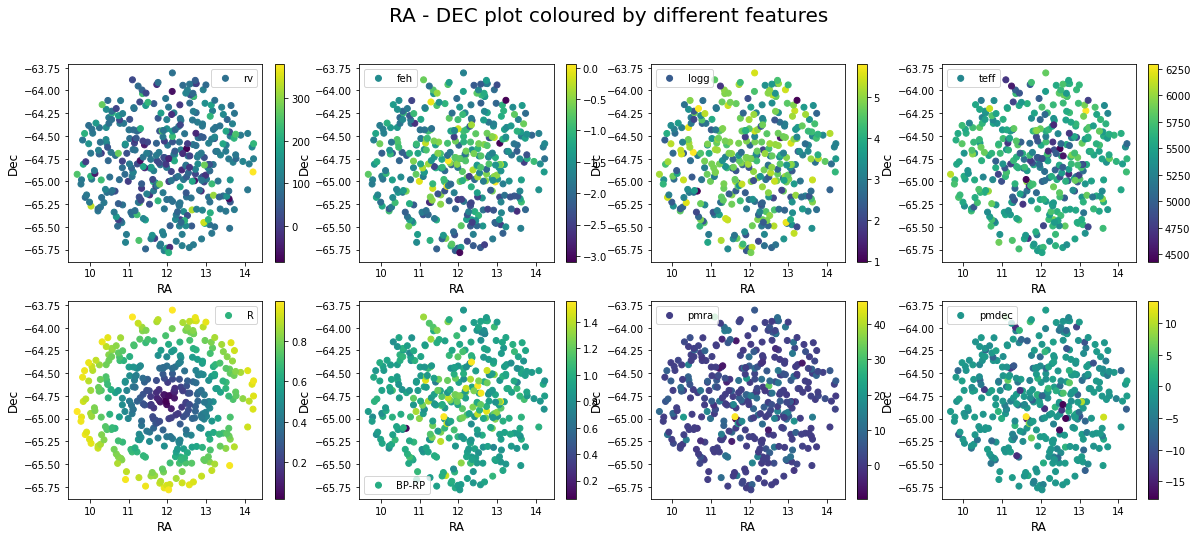

In [165]:
plt.subplots(figsize=(20,8))
plt.suptitle("RA - DEC plot coloured by different features", fontsize=20)
plt.subplot(2,4,1)
plt.scatter(table_cut['ra'],table_cut['dec'], c=table_cut['vel_calib'],cmap='viridis',label = 'rv')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,2)
plt.scatter(table_cut['ra'],table_cut['dec'], c=table_cut['feh50'],cmap='viridis',label = 'feh')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,3)
plt.scatter(table_cut['ra'],table_cut['dec'], c=table_cut['logg50'],cmap='viridis',label = 'logg')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,4)
plt.scatter(table_cut['ra'],table_cut['dec'], c=table_cut['teff50'],cmap='viridis',label = 'teff')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,5)
plt.scatter(table_cut['ra'],table_cut['dec'], c=table_cut['R'],cmap='viridis',label = 'R')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,6)
plt.scatter(table_cut['ra'],table_cut['dec'], c=table_cut['BP-RP'],cmap='viridis',label = 'BP-RP')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,7)
plt.scatter(table_cut['ra'],table_cut['dec'], c=table_cut['pmra'],cmap='viridis',label = 'pmra')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,8)
plt.scatter(table_cut['ra'],table_cut['dec'], c=table_cut['pmdec'],cmap='viridis',label = 'pmdec')
plt.xlabel('RA', size=12)
plt.ylabel('Dec', size=12)
plt.colorbar()
plt.legend()

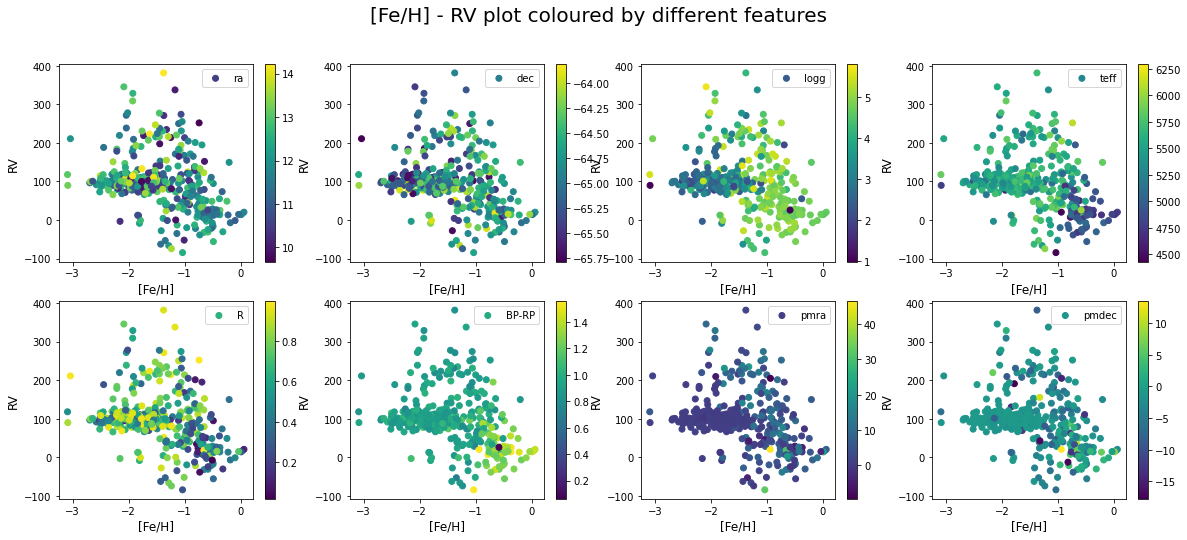

In [168]:
plt.subplots(figsize=(20,8))
plt.suptitle("[Fe/H] - RV plot coloured by different features", fontsize=20)
plt.subplot(2,4,1)
plt.scatter(table_cut['feh50'],table_cut['vel_calib'], c=table_cut['ra'],cmap='viridis',label = 'ra')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,2)
plt.scatter(table_cut['feh50'],table_cut['vel_calib'], c=table_cut['dec'],cmap='viridis',label = 'dec')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,3)
plt.scatter(table_cut['feh50'],table_cut['vel_calib'], c=table_cut['logg50'],cmap='viridis',label = 'logg')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,4)
plt.scatter(table_cut['feh50'],table_cut['vel_calib'], c=table_cut['teff50'],cmap='viridis',label = 'teff')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,5)
plt.scatter(table_cut['feh50'],table_cut['vel_calib'], c=table_cut['R'],cmap='viridis',label = 'R')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,6)
plt.scatter(table_cut['feh50'],table_cut['vel_calib'], c=table_cut['BP-RP'],cmap='viridis',label = 'BP-RP')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,7)
plt.scatter(table_cut['feh50'],table_cut['vel_calib'], c=table_cut['pmra'],cmap='viridis',label = 'pmra')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.colorbar()
plt.legend()
plt.subplot(2,4,8)
plt.scatter(table_cut['feh50'],table_cut['vel_calib'], c=table_cut['pmdec'],cmap='viridis',label = 'pmdec')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.colorbar()
plt.legend()